This example shows how to do text classification starting from raw text (as a set of text files on disk). We demonstrate the workflow on the IMDB sentiment classification dataset (unprocessed version). We use the TextVectorization layer for word splitting & indexing.

In [33]:
import tensorflow as tf
import numpy as np

### Data Preparation

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  53.6M      0  0:00:01  0:00:01 --:--:-- 53.6M


The aclImdb/train/pos and aclImdb/train/neg folders contain text files, each of which represents one review (either positive or negative):

In [3]:
!cat aclImdb/train/pos/6248_7.txt

Being an Austrian myself this has been a straight knock in my face. Fortunately I don't live nowhere near the place where this movie takes place but unfortunately it portrays everything that the rest of Austria hates about Viennese people (or people close to that region). And it is very easy to read that this is exactly the directors intention: to let your head sink into your hands and say "Oh my god, how can THAT be possible!". No, not with me, the (in my opinion) totally exaggerated uncensored swinger club scene is not necessary, I watch porn, sure, but in this context I was rather disgusted than put in the right context.<br /><br />This movie tells a story about how misled people who suffer from lack of education or bad company try to survive and live in a world of redundancy and boring horizons. A girl who is treated like a whore by her super-jealous boyfriend (and still keeps coming back), a female teacher who discovers her masochism by putting the life of her super-cruel "lover" 

We are only interested in the pos and neg subfolders, so let's delete the rest:

In [4]:
!rm -r aclImdb/train/unsup

You can use the utility tf.keras.preprocessing.text_dataset_from_directory to generate a labeled tf.data.Dataset object from a set of text files on disk filed into class-specific folders.

Let's use it to generate the training, validation, and test datasets. The validation and training datasets are generated from two subsets of the train directory, with 20% of samples going to the validation dataset and 80% going to the training dataset.

Having a validation dataset in addition to the test dataset is useful for tuning hyperparameters, such as the model architecture, for which the test dataset should not be used.

Before putting the model out into the real world however, it should be retrained using all available training data (without creating a validation dataset), so its performance is maximized.

When using the validation_split & subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation & training splits you get have no overlap.

In [9]:
BATCH_SIZE = 32
RANDOM_SEED = 43

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=RANDOM_SEED
)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=RANDOM_SEED
)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=BATCH_SIZE
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 625
Number of batches in raw_val_ds: 157
Number of batches in raw_test_ds: 782


Let's preview a few samples.

> `NOTE` : take(1) returns all the samples in the first batch of the dataset. Since our batch size is 32, take(1) will return total 32 examples

In [12]:
# It's important to take a look at your raw data to ensure your normalization
# and tokenization will work as expected. We can do that by taking a few
# examples from the training set and looking at them.
# This is one of the places where eager execution shines:
# we can just evaluate these tensors using .numpy()
# instead of needing to evaluate them in a Session/Graph context.

for text_batch, label_batch in raw_train_ds.take(1):
    print('*'*50)
    print('Total Examples in take(1) of the dataset : ', len(text_batch))
    print('*'*50)
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

**************************************************
Total Examples in take(1) of the dataset :  32
**************************************************
b'Melissa Sagemiller,Wes Bentley,Eliza Dushku and Casey Affleck play young students at Middleton College in the town of Middleton.The four teenagers form two love triangles.One night during an ominous full moon they drive and argue along a slippery and twisting mountain road.Not looking properly they careen into another car and one or more of them are killed.The ghostly nightmare begins...Pretty lousy and politically correct horror flick without gore and nudity.It\'s obviously influenced by "Carnival of Souls".The cinematography is decent,unfortunately there is zero suspense.4 out of 10-just another instantly forgettable teeny-bopper trash.'
0
b"There's about 25 years worth of inspiration packed into it. Beginning with existential themes of Blade Runner, as well as the vision of the future - with corporate billboards advertising their prod

#### Data Cleaning


In particular, we remove "\<br />" (Line Break) tags.

In [17]:
import string
import re
from keras.layers import TextVectorization

# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.
def custom_standardization(input_data):

  # Lower input data
  lowercase = tf.strings.lower(input_data)

  # Replace line breaks with space
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

  # Remove punctuations
  rem_puncts = tf.strings.regex_replace(
      stripped_html, f"[{re.escape(string.punctuation)}]", ''
      )

  return rem_puncts

# Testing on a random string
custom_standardization('This, is the text string ,<br />??')

<tf.Tensor: shape=(), dtype=string, numpy=b'this is the text string  '>

Model constants.

In [18]:
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [19]:
# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

### Two options to vectorize the data

There are 2 ways we can use our text vectorization layer:

`Option 1`: Make it part of the model, so as to obtain a model that processes raw strings, like this:


>text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')\
x = vectorize_layer(text_input)\
x = layers.Embedding(max_features + 1, embedding_dim)(x)\
...

`Option 2` : Apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs.

An important difference between the two is that option 2 enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So if you're training the model on GPU, you probably want to go with this option to get the best performance. This is what we will do below.

If we were to export our model to production, we'd ship a model that accepts raw strings as input, like in the code snippet for option 1 above. This can be done after training. We do this in the last section.

In [20]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

Let's see an example

In [22]:
for text_batch, label_batch in train_ds.take(1):
    print('*'*50)
    print('Total Examples in take(1) of the dataset : ', len(text_batch))
    print('*'*50)
    for i in range(1):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

**************************************************
Total Examples in take(1) of the dataset :  32
**************************************************
[    2   287  4313     8     4   795  1935   983     1   371 12998     8
     2 18429    13   963     6  4296     2  4313   218   355    16     2
   983   638     8     4 12173    44    37    11    13     4  2078    94
     6  1022    57     4  2203  2766  2996     1    14  9242     7     4
  2235   180   684     3  1101  9644  5929    14     2  1948  4815     3
 15087  4348    14     2  8734  5010    23   179   363     2     1     1
    23     4     1   588    65   668    23   175     1   188    11     7
     2  4897    21     2  1865    37     2    19   146   590   750    47
    23     4   165   913    18     2  4313  3733     5   467     7    50
  8380    70   617     2   655  1767     7    81     1 12998     8     2
 18429     1 13441     1  5989  2086  2547   471  5476  2086  1101  9644
  5929     0     0     0     0     0     0     0

## Build a model
We choose a simple 1D convnet starting with an Embedding layer.

In [24]:
from tensorflow.keras import layers

In [28]:
# Integer input for Vocab indices
inputs = tf.keras.Input(shape=(None,),dtype='int64')

# Next, we add a layer to map those vocab indices into a space of dimensionality - 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(rate=0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [29]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 128)         2560000   
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         114816    
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                           

### Train the model

In [32]:
epochs = 3

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
) 

Epoch 1/3
625/625 [==============================] - 128s 205ms/step - loss: 0.3869 - accuracy: 0.8278 - val_loss: 0.2933 - val_accuracy: 0.8844
Epoch 2/3
625/625 [==============================] - 122s 196ms/step - loss: 0.1862 - accuracy: 0.9284 - val_loss: 0.3351 - val_accuracy: 0.8840
Epoch 3/3
625/625 [==============================] - 121s 194ms/step - loss: 0.1005 - accuracy: 0.9626 - val_loss: 0.4994 - val_accuracy: 0.8708


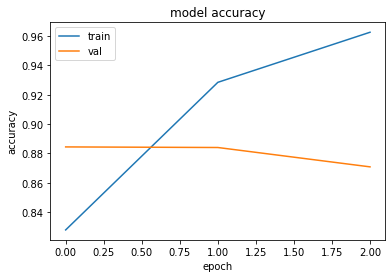

In [38]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Looks like a bit of overfit model

### Evaluate the model on the test set

In [39]:
model.evaluate(test_ds)

782/782 [==============================] - 34s 43ms/step - loss: 0.4932 - accuracy: 0.8624


[0.49324971437454224, 0.8623600006103516]

86.23% Accuracy on Test Dataset!

### Make an end-to-end model

If you want to obtain a model capable of processing raw strings, you can simply create a new model (using the weights we just trained):

In [40]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.evaluate(raw_test_ds)

782/782 [==============================] - 38s 47ms/step - loss: 0.4932 - accuracy: 0.8624


[0.49324971437454224, 0.8623600006103516]

### Create Confusion Matrix

In [129]:
threshold = 0.1

y_predict=model.predict(test_ds)

pred_labels = [leaf for tree in np.where(y_predict > threshold, 0,1) for leaf in tree]
true_labels = np.concatenate([y for x, y in raw_test_ds], axis=0)

res = tf.math.confusion_matrix(pred_labels,true_labels)
res

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[6779, 6823],
       [5721, 5677]], dtype=int32)>